In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600 
    #'savefig.bbox' : 'tight'
})
from scipy import linalg
from scipy.constants import hbar

In [2]:
def Euler(f, x, t, h):
    return x + h*f(x,t)
def RK2(f, x, t, h):
    k1 = h*f(x, t)
    k2 = h*f(x+0.5*k1, t+0.5*h)
    return x+k2
def RK4(f, x, t, h):
    k1 = h*f(x, t)
    k2 = h*f(x+0.5*k1, t+0.5*h)
    k3 = h*f(x+0.5*k2, t+0.5*h)
    k4 = h*f(x+k3, t+h)
    return x+ (k1+2*k2+2*k3+k4)/6.
def verlet(f, X, h, t):
    x, p = X
    p += 0.5*h*f(x, t)
    x += h*p
    p += 0.5*h*f(x, t)
    return np.array([x,p])

# I. The Lorenz Equations

In [3]:
sigma = 10
r = 28
b = 8./3
def f(X, t):
    x,y,z = X
    fx = sigma*(y-x)
    fy = r*x - y - x*z
    fz = x*y - b*z
    return np.array([fx,fy,fz])

In [4]:
T = 50
N = 10000
t = np.linspace(0, T, N)
h = t[1]-t[0]

X = np.zeros((N, 3))
X[0,1] = 1

for i in range (N-1):
    X[i+1] = RK4(f, X[i], t[i], h)

In [11]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!ls '/content/drive/My Drive/Colab Notebooks'

Untitled.ipynb


0.005000500050005001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

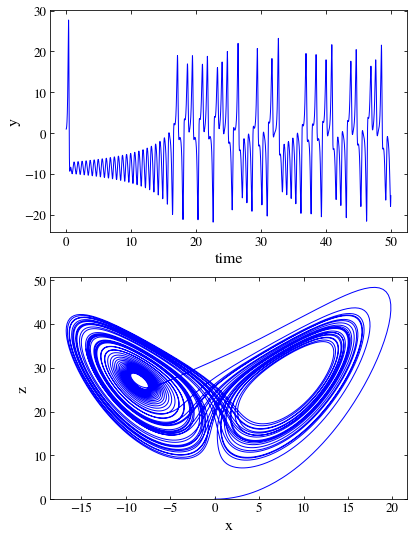

In [13]:
print(h)
fig, ax = plt.subplots(2, 1, figsize=(6.4, 9))

ax[0].plot(t, X[:, 1], 'b-', lw=1)
ax[0].set_xlabel('time')
ax[0].set_ylabel('y')

ax[1].plot(X[:,0],X[:,2], 'b-', lw = 1)
ax[1].set_ylim(0)
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

plt.savefig('fin_1.png')
files.download("fin_1.png")

# II. An Electronic Capacitor

In [14]:
M = 100
acc = 1e-6

phi = np.zeros((M, M))
phi[20:80, 20] = 1
phi[20:80, 80] = -1
d = 1.

start = time()
while d>acc:
    d = 0.
    for i in range (1, M-2):
        for j in range (1, M-2):
            if j==20 or j==80:
                if i>=20 and i<80: continue
            tmp = 0.25*(phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])
            d = max(d, abs(phi[i,j]-tmp))
            phi[i,j] = tmp
print(time()-start)

50.60389828681946


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

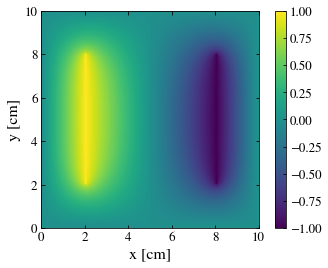

In [15]:
ax = plt.gca()
im = ax.imshow(phi, extent=[0, 10, 0, 10])
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
cb = plt.colorbar(im)

plt.savefig('fin_2.png')
files.download("fin_2.png")

# III. Schrodinger Equation + Cranck-Nocolson

In [16]:
h = 1e-18
sigma = 1e-10
k = 5*1e10
L = 1e-8
m = 9.109e-31
x_0 = L/2.
hbar

1.0545718176461565e-34

In [17]:
def wavef(x):
    return np.exp(-0.5*(x-x_0)**2/sigma**2)*np.exp(1j*k*x)

In [18]:
N = 1000
a = L/N

a1 = 1. + 0.5j * h*hbar/(m*a**2)
a2 = - 0.25j * h*hbar/(m*a**2)
b1 = 1. - 0.5j * h*hbar/(m*a**2)
b2 = 0.25j * h*hbar/(m*a**2)
A = np.zeros((N-1, N-1), complex)
B = np.zeros_like(A)
np.fill_diagonal(A, a1)
np.fill_diagonal(A[1:,:], a2)
np.fill_diagonal(A[:,1:], a2)
np.fill_diagonal(B, b1)
np.fill_diagonal(B[1:,:], b2)
np.fill_diagonal(B[:,1:], b2)

x = np.linspace(0, L, N+1)

In [19]:
step = 10000
psi = np.zeros((step, N+1), complex)
psi[0] = wavef(x)

start = time()
for i in range (step-1):
    v = B.dot(psi[i, 1:N])
    psi[i+1, 1:N] = linalg.solve(A, v, assume_a = 'sym')
print(time()-start)

1826.5466673374176


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

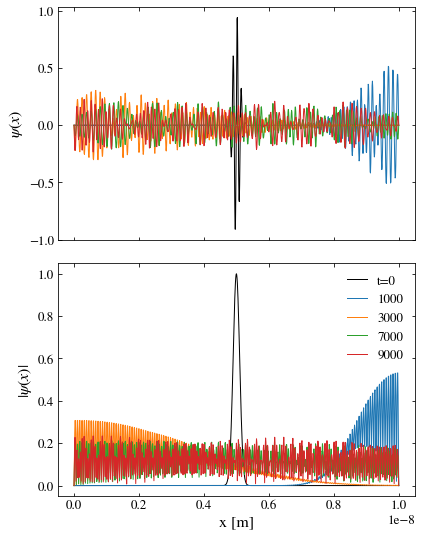

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(6.4, 9), sharex=True)

ax[0].plot(x, psi[0].real, 'k-', lw=1, label='t=0')
ax[1].plot(x, np.abs(psi[0]), 'k-', lw=1, label='t=0')
for i in [1000, 3000, 7000, 9000]:
    ax[0].plot(x, psi[i].real, lw=1, label=i)
    ax[1].plot(x, np.abs(psi[i]), lw=1, label=i)
ax[1].legend()

ax[1].set_xlabel('x [m]')
ax[0].set_ylabel(r'$\psi (x)$')
ax[1].set_ylabel(r'$|\psi (x)|$')

plt.subplots_adjust(hspace=0.1)
plt.savefig('fin_3.png')
files.download("fin_3.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

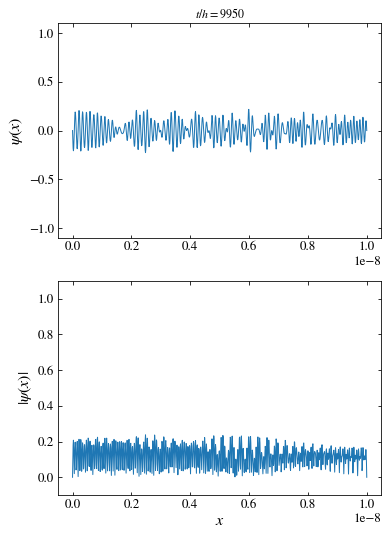

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
mpl.rcParams['animation.embed_limit'] = 2**128
plt.rcParams["savefig.dpi"] = 100

fig = plt.figure(figsize=(5.8, 8.7))
ax1 = fig.add_subplot(211, xlim=(-L*0.05,L*1.05), ylim=(-1.1, 1.1))
ax2 = fig.add_subplot(212, xlim=(-L*0.05,L*1.05), ylim=(-0.1, 1.1))
title=ax1.set_title("")
ax2.set_xlabel('$x$')
ax1.set_ylabel(r'$\psi(x)$')
ax2.set_ylabel(r'$|\psi(x)|$')
Psi, = ax1.plot([], [], lw=1)
absPsi, = ax2.plot([], [], lw=1)
def init():
    title.set_text("")
    Psi.set_data([], [])
    absPsi.set_data([], [])
    return (Psi, absPsi)
def animate(i):
    a = 50*i
    title.set_text(r"$t/h=%d$"%a)
    x = np.linspace(0, L, N+1)
    Psi.set_data(x, psi[50*i].real)
    absPsi.set_data(x, np.abs(psi[50*i]))
    return (Psi, absPsi)

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=200, interval=20, blit=True, repeat=False)

HTML(anim.to_jshtml())
anim.save('electron.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

files.download("electron.mp4")